<a href="https://colab.research.google.com/github/HoseinNekouei/sentiment_analysis/blob/main/text_aspect_generation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libreries and important requirment**

In [ ]:
!pip install datasets

In [ ]:
# Standard library imports
import os
import re
import logging
from typing import Optional
from google.colab import output

# Third-party library imports
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from typing import Optional
from datasets import Dataset

# Download NLTK data
nltk.download('stopwords')

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir /content/dataset
!cp /content/drive/MyDrive/Projects/Sentiment_Analysis/Augmented_dataset_US_airline_Tweet.csv /content/dataset

mkdir: cannot create directory ‘/content/dataset’: File exists


# **Load Dataset and Pre-Processing data**

In [ ]:
# visualize Data variation
class DataVisualizer:
    @staticmethod
    def visualize_sentiment(data):
        sentiment_count = data.labels.value_counts()
        colors = sns.color_palette('pastel', 3)
        labels = ['Negative', 'Neutral', 'Positive']
        explode = [0.01, 0.01, 0.01]

        plt.figure(figsize=(4, 4))
        sentiment_count.plot(
            kind='pie',
            colors=colors,
            labels=labels,
            explode=explode,
            shadow=True,
            autopct='%.2f',
            fontsize=12,
        )
        plt.title('Total Tweets for Each Sentiment')
        plt.ylabel(' ')
        plt.show()

In [ ]:
class TextProcessor:
    @staticmethod
    def class_mapping(sentiment: str)-> int:
        """ Map class labels to new values."""
        sentiment_mapping={
            'negative': 0,
            'neutral': 1,
            'positive': 2,
        }
        return sentiment_mapping.get(sentiment, -1)

    # Remove url
    @staticmethod
    def remove_urls(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)

    # Remove html
    @staticmethod
    def remove_html(text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)

    # Decontraction text
    @staticmethod
    def decontraction(text):
        contractions = {
            r"won\'t": " will not",
            r"won\'t've": " will not have",
            r"can\'t": " can not",
            r"don\'t": " do not",
            r"didn\'t": " did not",
            r"can\'t've": " can not have",
            r"ma\'am": " madam",
            r"let\'s": " let us",
            r"ain\'t": " am not",
            r"shan\'t": " shall not",
            r"sha\n't": " shall not",
            r"o\'clock": " of the clock",
            r"y\'all": " you all",
            r"n\'t": " not",
            r"n\'t've": " not have",
            r"\'re": " are",
            r"\'s": " is",
            r"\'d": " would",
            r"\'d've": " would have",
            r"\'ll": " will",
            r"\'ll've": " will have",
            r"\'t": " not",
            r"\'ve": " have",
            r"\'m": " am",
            r"\'re": " are",
        }
        for pattern, replacement in contractions.items():
            text = re.sub(pattern, replacement, text)
        return text

    @staticmethod
    def normalize_repeated_chars(text):
        # Preserve ellipses by temporarily replacing them with a unique placeholder
        placeholder = "<ELLIPSIS>"
        text = re.sub(r'\.{3,}', placeholder, text)  # Replace ellipses with a placeholder
        # Normalize repeated characters. Matches any character repeated 3 or more times like cooool -> cool
        text = re.sub(r'(.)\1{2,}', r'\1', text)
        # Restore ellipses by replacing the placeholder with '...'
        text = text.replace(placeholder, '...')
        return text

In [ ]:
class DatasetLoader:
    def __init__(self, *, file_path: str):
        self.file_path: str = file_path
        self._data: Optional[pd.DataFrame] = None

    def loader(self) -> pd.DataFrame:
        if not os.path.exists(self.file_path):
            logging.error(f"File not found: {self.file_path}")
            raise FileNotFoundError(f"File not found: {self.file_path}")
        try:
            self._data = pd.read_csv(self.file_path, nrows=100)
            logging.info("Data loaded successfully.")
        except Exception as e:
            logging.error(f"Error loading data: {e}")
            raise
        return self._data

    def visualize_data(self)-> pd.DataFrame:
        if self._data is None:
            raise ValueError("Data not loaded. Call `loader()` first.")
        DataVisualizer.visualize_sentiment(self._data)
        return self._data

    def map_classes(self)-> pd.DataFrame:
        if self._data is None:
            raise ValueError("Data not loaded. Call `loader()` first.")
        self._data['labels'] = self._data['labels'].apply(TextProcessor.class_mapping)
        return self._data

    def text_preprocessing(self)-> pd.DataFrame:
        if self._data is None:
            raise ValueError("Data not loaded. Call `loader()` first.")

        # Apply the static method to remove html
        self._data['revised_text']= self._data['text'].apply(TextProcessor.remove_html)
        # Apply the static method to remove urls
        self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.remove_urls)
        # Apply the static method to decontract text.
        self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.decontraction)
        # Convert texts to lowercase.
        self._data['revised_text']= self._data['revised_text'].apply(lambda x: x.lower())
        # Replace Repeated Characters with a Single Instance
        self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.normalize_repeated_chars)

    def __str__(self):
        if self._data is None:
            return "Data not loaded."
        information = [
            f'Categories of : {self._data.labels.value_counts().to_dict()}',
            f'\nInformation: {self._data.info()}'
        ]
        return ', '.join(information)

    def __call__(self)-> pd.DataFrame:
        self.loader()
        self.visualize_data()
        self.map_classes()
        self.text_preprocessing()
        return self._data


# **Generate aspect of each text by text2text generation LLM**

In [ ]:
from transformers import T5ForConditionalGeneration, T5TokenizerFast

class AspectGeneration:
    def __init__(self, *, model_name, texts, batch_size=128, prompt):
        self.model_name = model_name
        self.texts = texts
        self.batch_size = batch_size
        self.prompt = prompt
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = None
        self.tokenizer = None

    def load_model(self):
        """Load the T5 model and tokenizer."""
        self.model = T5ForConditionalGeneration.from_pretrained(self.model_name, device_map='auto', torch_dtype=torch.float16)
        self.tokenizer = T5TokenizerFast.from_pretrained(self.model_name)
        self.model.to(self.device)

    def text_augmentation(self):
        """Generate augmented texts using the T5 model."""
        augmented_texts = []

        for i in range(0, len(self.texts), self.batch_size):
            batch = self.texts[i:i + self.batch_size]
            prompts = [self.prompt + text for text in batch]

            # Tokenize and generate
            inputs = self.tokenizer(
                prompts,
                return_tensors='pt',
                padding=True,
                truncation=True
            ).to(self.device)

            outputs = self.model.generate(
                **inputs,
                max_length=50,
                num_return_sequences=1
            )

            # Decode and combine
            generated_texts = self.tokenizer.batch_decode(outputs, skip_special_tokens=True)

            print(f'Generated {i}/{len(self.texts)} texts')

            for original_text, generated_text in zip(batch, generated_texts):
                augmented_texts.append(f"{original_text} [START_ASPECT] {generated_text} [END_ASPECT]")

        return augmented_texts


    def create_dataset(self, augmented_texts, labels=None, save_path=None):

        dataset_dict = {"text": augmented_texts}
        if labels is not None:
            dataset_dict["labels"] = labels

        # Create a Hugging Face Dataset
        dataset = Dataset.from_dict(dataset_dict)

        # Convert to Pandas DataFrame
        df = pd.DataFrame(dataset_dict)

        # Save to CSV if a save path is provided
        if save_path:
            try:
                df.to_csv(save_path, index=False)
                print(f"Dataset saved successfully to {save_path}")
            except Exception as e:
                print(f"Error saving dataset to {save_path}: {e}")

        return dataset, df

    def __call__(self, labels=None, save_path=None):
        self.load_model()
        augmented_texts = self.text_augmentation()

        if labels is not None:
            dataset, df = self.create_dataset(augmented_texts, labels, save_path)
            return augmented_texts, dataset, df
        else:
            return augmented_texts

# **Sentiment Analysis block**

In [ ]:
del flan_model
del flan_tokenizer

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# load _data

# !mkdir /content/dataset
# !cp /content/drive/MyDrive/Projects/Sentiment_Analysis/twitter_train_corpus.csv /content/dataset

# train_data= pd.read_csv("/content/dataset/twitter_train_corpus.csv")
# len(train_data)

mkdir: cannot create directory ‘/content/dataset’: File exists


40673

In [ ]:
import math
from torch.optim import AdamW
from sklearn.model_selection import KFold
from transformers import  AutoTokenizer,AutoModelForSequenceClassification

epochs= 2
batch_size= 32
check_point= 'cardiffnlp/twitter-roberta-base-sentiment-latest'

sentiment_tokenizer = AutoTokenizer.from_pretrained(check_point)
sentiment_model= AutoModelForSequenceClassification.from_pretrained(check_point, device_map='auto')
optim = AdamW(sentiment_model.parameters(), lr=5e-5)

# # Freeze all layers except the classifier
# for param in sentiment_model.roberta.parameters():
#     param.requires_grad = False

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

def tokenize(texts):
    if not isinstance(texts, list):
        texts= texts.tolist()

    train_encoding= sentiment_tokenizer(
        texts,
        padding=True,
        max_length= 256,
        truncation= True,
        return_tensors= 'pt')

    return train_encoding

In [ ]:
# preparing train encoding
texts= train_data['text']
labels= train_data['labels'].tolist()

train_encoding= tokenize(texts)
len(train_encoding['input_ids'])

40673

In [ ]:
# Initialize KFold with k=5
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Store accuracy scores for each fold
accuracy_scores = []
labels = torch.tensor(labels).to(device)
input_ids=train_encoding['input_ids'].to(device)
attention_mask= train_encoding['attention_mask'].to(device)

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(input_ids)):
    print(f"Fold {fold + 1}...")

    # Split data into training and validation sets
    train_input_ids, val_input_ids = input_ids[train_idx], input_ids[val_idx]
    train_attention_mask, val_attention_mask = attention_mask[train_idx], attention_mask[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Create PyTorch datasets and dataloaders
    train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
    val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_labels)

    train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size= batch_size)

    # Train the model
    sentiment_model.train()
    for epoch in range(epochs):  # Number of epochs
        for i, batch in enumerate(train_loader):
            optim.zero_grad()
            input_ids_batch, attention_mask_batch, labels_batch = batch
            outputs = sentiment_model(input_ids_batch, attention_mask=attention_mask_batch, labels=labels_batch)
            loss = outputs.loss
            loss.backward()
            optim.step()

            if (i + 1) % 100 == 0:
                denominator = math.ceil(len(train_loader.dataset) / batch_size)
                print(f'[Epoch: {epoch + 1}] -> Batch: [{i + 1}/{denominator} ]')

        print(f'[Epoch: {epoch + 1}] -> Batch: [{denominator}/{denominator}]')

    # Evaluate the model on the validation set
    sentiment_model.eval()
    fold_accuracy= 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids_batch, attention_mask_batch, labels_batch = batch
            outputs = sentiment_model(input_ids_batch, attention_mask=attention_mask_batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            fold_accuracy += torch.sum(preds == labels_batch).item()

        fold_accuracy /= len(val_idx)

    # Calculate accuracy for this fold
    accuracy_scores.append(fold_accuracy)
    print(f"Validation Accuracy: {fold_accuracy:.4f}")
    print('=' * 40)

accuracy_scores = torch.tensor(accuracy_scores)
# Output the results
print(f"Cross-validation accuracy scores: {accuracy_scores}")
print(f"Mean accuracy: {torch.mean(accuracy_scores):.4f}")
print(f"Standard deviation: {torch.std(accuracy_scores):.4f}")

# Save the model
torch.save(sentiment_model, '/content/drive/MyDrive/Projects/Sentiment_Analysis/senti_model_batch16.pt')
print('\nmodel saved!')

Fold 1...
[Epoch: 1] -> Batch: [100/2034 ]
[Epoch: 1] -> Batch: [200/2034 ]
[Epoch: 1] -> Batch: [300/2034 ]


# **Test block**

In [ ]:
#load model
senti_model= torch.load('/content/drive/MyDrive/Projects/Sentiment_Analysis/senti_model_batch16.pt')
senti_model

In [ ]:
# load _test_data

!cp /content/drive/MyDrive/Projects/Sentiment_Analysis/twitter_test_corpus.csv /content/dataset

test_data= pd.read_csv("/content/dataset/twitter_test_corpus.csv")
len(test_data)

In [ ]:
# preparing test data
test_texts= test_data['text']
test_labels= test_data['labels'].tolist()

test_encoding= tokenize(test_texts)
len(train_encoding['input_ids'])

In [ ]:
test_labels = torch.tensor(test_labels).to(device)
test_input_ids= test_encoding['input_ids'].to(device)
test_attention_mask= test_encoding['attention_mask'].to(device)
print(len(input_ids))

# Create PyTorch datasets and dataloaders
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)
test_loader = DataLoader(test_dataset, batch_size= batch_size)

with torch.no_grad():
    test_accuracy= 0

    for batch in test_loader:
        input_ids_batch, attention_mask_batch, labels_batch = batch
        outputs = sentiment_model(input_ids_batch, attention_mask=attention_mask_batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        fold_accuracy += torch.sum(preds == labels_batch).item()

    test_accuracy /= len(input_ids)

# Calculate accuracy
print(f"\nTest Accuracy: {test_accuracy:.4f}")

#**Useing File**

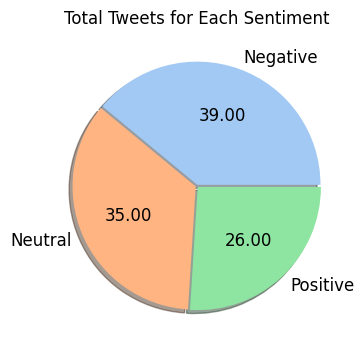

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            100 non-null    object
 1   labels          100 non-null    int64 
 2   negativereason  35 non-null     object
 3   positivereason  26 non-null     object
 4   revised_text    100 non-null    object
dtypes: int64(1), object(4)
memory usage: 4.0+ KB
Categories of : {1: 39, 0: 35, 2: 26}, 
Information: None
Generated 0/100 texts
Generated 0/100 texts
Dataset saved successfully to /content/drive/MyDrive/Projects/Sentiment_Analysis/aspect_generation/twitter_train_corpus.csv
Augmented Texts:
@VirginAmerica What @dhepburn said. [START_ASPECT] Tweets from @VirginAmerica are typically positive and supportive. [END_ASPECT]
@VirginAmerica plus you've added commercials to the experience... tacky. [START_ASPECT] The speaker is critical of the commercials added to the experience. [END_ASPEC

In [ ]:
if __name__ == "__main__":
    file_path= '/content/drive/MyDrive/Projects/Sentiment_Analysis/aspect_generation/Augmented_dataset_US_airline_Tweet.csv'
    loader= DatasetLoader(file_path= file_path)
    loader() # Load, visualize, map classes, and preprocess data
    print(loader)

    texts= loader._data['text']
    labels= loader._data['labels']

    batch_size= 512
    model_name = "google/flan-t5-large"
    prompt = "Provide a brief explanation the interpretation of the key emotional aspects and tone: "

    aspect_generator = AspectGeneration(model_name=model_name, batch_size= batch_size, texts=texts, prompt=prompt)
    augmented_texts = aspect_generator()

    save_path="/content/drive/MyDrive/Projects/Sentiment_Analysis/aspect_generation/twitter_train_corpus.csv"
    # Generate augmented texts and create dataset
    augmented_texts, dataset, df = aspect_generator(labels=labels, save_path= save_path )

    # Print results
    print("Augmented Texts:")
    [print(text) for text in augmented_texts[:5]]

    print("\nHugging Face Dataset:")
    print(dataset)

    print("\nPandas DataFrame:")
    print(df)

In [ ]:
[print(text) for text in augmented_texts[:5]]

@VirginAmerica What @dhepburn said. [START_ASPECT] Tweets from @VirginAmerica are typically positive and supportive. [END_ASPECT]
@VirginAmerica plus you've added commercials to the experience... tacky. [START_ASPECT] The speaker is critical of the commercials added to the experience. [END_ASPECT]
@VirginAmerica I didn't today... Must mean I need to take another trip! [START_ASPECT] The speaker is expressing disappointment that they didn't go on a trip today. [END_ASPECT]
@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse [START_ASPECT] It's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse [END_ASPECT]
@VirginAmerica and it's a really big bad thing about it [START_ASPECT] Tweeter @VirginAmerica is upset about the situation. [END_ASPECT]


[None, None, None, None, None]